# Inverse Reinforcement Learning in Mountain Car Environment

---

Inverse Reinforcement Learning (IRL) is a paradigm in imitation learning where the primary aim is to deduce the reward function given the observed behavior of an expert. This is crucial in domains such as autonomous driving, robotics, and more, where designing a reward function is challenging.

The implementation here uses a Maximum Entropy Inverse Reinforcement Learning (MaxEnt IRL) approach on the classic Mountain Car problem in OpenAI's Gym. Most parts of this notebook is based on [this repo](https://github.com/reinforcement-learning-kr/lets-do-irl/).

## Setup and Dependencies

Before running the code, ensure you have installed the required packages. If not, you can install them via:

In [1]:
# ! pip install gym numpy matplotlib --quiet

Now, we download the expert demonstration data for the Mountain Car environment.

In [2]:
# ! wget https://github.com/reinforcement-learning-kr/lets-do-irl/raw/refs/heads/master/mountaincar/maxent/expert_demo/expert_demo.npy -q

The states in the Mountain Car environment consist of the position and velocity of the car. We consider discretizing the the state into multiple bins, and represent the state with only one number, which is calculated by
`state = discretized_pos + discretized_vel * N_BIN`

In [11]:
import numpy as np
import gym

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


env = gym.make('MountainCar-v0')
n_bins = 20

n_states = n_bins * n_bins
n_actions = 3

def discretize_state(position, velocity):
    env_low = env.observation_space.low
    env_high = env.observation_space.high
    env_distance = (env_high - env_low) / n_bins
    position_idx = int((position - env_low[0]) / env_distance[0])
    velocity_idx = int((velocity - env_low[1]) / env_distance[1])
    state_idx = position_idx + velocity_idx * n_bins
    return state_idx

We can now load the expert demonstration data as follows. The demonstration numpy array has the following shape:

`(number of trajectories, the length of each trajectory, 2)`

Note that in the last dimension, the first column represents the discretized state and the second one represents the action taken by the expert.

In [12]:
raw_demo = np.load(file="./expert_demo.npy")
expert_demo = np.zeros((len(raw_demo), len(raw_demo[0]), 2))

for x in range(len(raw_demo)):
    for y in range(len(raw_demo[0])):
        state_idx = discretize_state(raw_demo[x][y][0], raw_demo[x][y][1])
        expert_demo[x][y][0] = state_idx
        expert_demo[x][y][1] = raw_demo[x][y][2]


In [13]:
print(expert_demo.shape)

(20, 130, 2)


## Reward Function

We consider a linear reward function, where each feature corresponds to one state, i.e., $r_\theta(s) = \theta^\top f_s$, where $f_s$ is a one-hot feature vector corresponding to state $s$.

In [14]:
feature_matrix = np.eye((n_states)) # (n_states, n_states)

def get_reward(theta, state_idx):
    irl_rewards = feature_matrix.dot(theta).reshape((n_states,))
    return irl_rewards[state_idx]

## Max-Entropy IRL

Now, we implement the main part of the code, which is training the Max-Entropy IRL algorithm. Recall that, according to the principle of maximum entropy, the expert policy optimizes the following objective function:

$$\max_{\pi} \mathbb{E}_{\tau\sim\pi} [J_\theta(\tau)] + H(\pi),$$

where $J_\theta(\tau) = \sum_{s \in \tau} r_\theta(s)$ is the total reward of a trajectory $\tau$ and $H$ is the entropy function. It can be shown that the resuling expert policy is the following:

$$P_{\theta}(\tau) \propto \exp \{J_\theta(\tau)\}.$$

One can then maximize the likelihood of observing the expert demonstration data ($\mathcal{L}_\theta$) under the above parametrized expert policy to learn $\theta$, and thus the reward functions. It can be shown that, under the linear assumption, the gradient of the likelihood function is (See https://www.youtube.com/live/J2blDuU3X1I?si=f0UyNvs2apUuFxGh&t=957 for the derivation)

$$\nabla_\theta \mathcal{L}_\theta = \frac{1}{N} \sum_{\tau_d} \sum_{s \in \tau_d} f_s - \sum_{s} d_\theta(s) f_s$$

where $\tau_d$s are expert demonstration data, $N$ is the total number of expert demonstration data, $d_\theta(s)$ is the probability of visiting state $s$ under the optimal policy corresponding to $r_\theta$, and $f_s$ is the one-hot feature vector corresponding to a state $s$. One can calculate the left-hand-side of the gradient above once using the following:


In [15]:
expert_feature_expectations = np.zeros(feature_matrix.shape[0])

for demonstration in expert_demo:
    for state_idx, _, in demonstration:
        expert_feature_expectations += feature_matrix[int(state_idx)]

expert_feature_expectations /= expert_demo.shape[0]

For the right-hand-side, however, we need to calculate the optimal policy. However, instead of analytical calculation, we can follow a value iteration algorithm that keeps updating the policy by keeping a track of q-values. In the meantime, we will keep updating $d_\theta(s)$, the probability of visiting a state $s$, by calculating the number of visits per state and dividing it by the total number of visits.  

0 episode score is -200.00
1000 episode score is -199.98
2000 episode score is -199.45
3000 episode score is -199.35
4000 episode score is -196.56
5000 episode score is -190.79
6000 episode score is -186.75
7000 episode score is -180.67
8000 episode score is -177.82
9000 episode score is -171.43
10000 episode score is -167.50
11000 episode score is -163.69
12000 episode score is -160.24
13000 episode score is -157.28
14000 episode score is -154.74
15000 episode score is -152.53
16000 episode score is -150.61
17000 episode score is -148.93
18000 episode score is -147.43
19000 episode score is -146.26
20000 episode score is -145.48
21000 episode score is -146.05
22000 episode score is -146.90
23000 episode score is -145.96
24000 episode score is -145.47
25000 episode score is -145.46
26000 episode score is -145.65
27000 episode score is -144.54
28000 episode score is -143.47
29000 episode score is -142.39


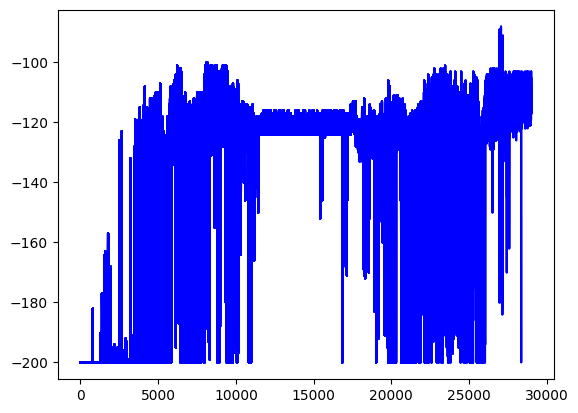

In [18]:
import pylab

q_table = np.zeros((n_states, n_actions))

gamma = 0.99
q_learning_rate = 0.03
theta_learning_rate = 0.05
num_episodes = 30000
warm_up_steps = 1000
update_steps = 500

np.random.seed(1)

def update_q_table(state, action, reward, next_state):
    q_1 = q_table[state][action]
    q_2 = reward + gamma * max(q_table[next_state])
    q_table[state][action] += q_learning_rate * (q_2 - q_1)


learner_feature_expectations = np.zeros(n_states)

theta = - np.random.uniform(size=(n_states,)) # randomly initialize theta

episodes, scores = [], []

for episode in range(num_episodes):
    state = env.reset()
    score = 0

    if (
        (episode != 0 and episode == warm_up_steps)
        or  (episode > warm_up_steps and episode % update_steps == 0)
    ):
        gradient = expert_feature_expectations - learner_feature_expectations / episode
        theta += theta_learning_rate * gradient # gradient ascent to maximize the likelihood
        # clip theta
        theta = np.clip(theta, a_min=None, a_max=0.)

    while True: # the value iteration loop
        state_idx = discretize_state(state[0], state[1])
        action = np.argmax(q_table[state_idx])
        next_state, reward, done, _ = env.step(action)

        irl_reward = get_reward(theta, state_idx)
        next_state_idx = discretize_state(next_state[0], next_state[1])
        update_q_table(state_idx, action, irl_reward, next_state_idx)

        # updating d_\theta(s)
        learner_feature_expectations += feature_matrix[int(state_idx)]

        score += reward
        state = next_state

        if done:
            scores.append(score)
            episodes.append(episode)
            break

    if episode % 1000 == 0:
        score_avg = np.mean(scores)
        print('{} episode score is {:.2f}'.format(episode, score_avg))
        pylab.plot(episodes, scores, 'b')
        pylab.savefig("maxent_30000.png")
        np.save("maxent_q_table", arr=q_table)


0 episode score is -115.00
1 episode score is -107.00
2 episode score is -114.00
3 episode score is -112.00
4 episode score is -116.00
5 episode score is -119.00
6 episode score is -118.00
7 episode score is -115.00
8 episode score is -117.00
9 episode score is -110.00


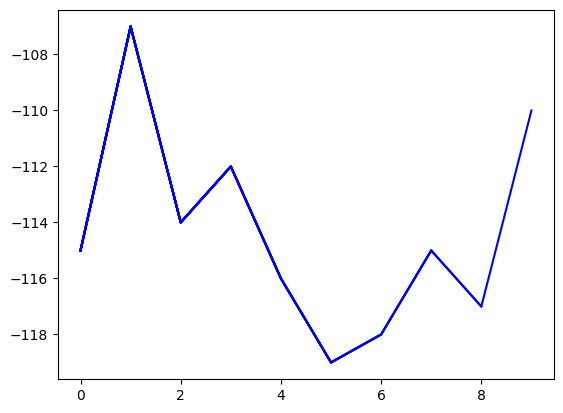

In [19]:
q_table = np.load(file="maxent_q_table.npy")

episodes, scores = [], []

for episode in range(10):
    state = env.reset()
    score = 0

    while True:
        env.render()
        state_idx = discretize_state(state[0], state[1])
        action = np.argmax(q_table[state_idx])
        next_state, reward, done, _ = env.step(action)

        score += reward
        state = next_state

        if done:
            scores.append(score)
            episodes.append(episode)
            pylab.plot(episodes, scores, 'b')
            pylab.savefig("maxent_test.png")
            break

    if episode % 1 == 0:
        print('{} episode score is {:.2f}'.format(episode, score))
